# 0) Setup & Reproducibility

In [1]:
import os, sys, random, time
import numpy as np
import torch, torchvision
import platform

# Global seed
SEED = 1337

# Fix seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Environment summary
print("Environment summary:")
print(f"  Python: {platform.python_version()}")
print(f"  torch: {torch.__version__}")
print(f"  torchvision: {torchvision.__version__}")
print(f"  Device available: {'cuda' if torch.cuda.is_available() else 'cpu'}")

# Reproducibility confirmation
print(f"\nSeed: {SEED} | cudnn.deterministic={torch.backends.cudnn.deterministic} | cudnn.benchmark={torch.backends.cudnn.benchmark}")

Environment summary:
  Python: 3.12.11
  torch: 2.8.0+cu126
  torchvision: 0.23.0+cu126
  Device available: cuda

Seed: 1337 | cudnn.deterministic=True | cudnn.benchmark=False


## 1) Model Architecture

In [2]:
# 1) Model Architecture (1.1, 1.2, 1.3)
import torch
import torch.nn as nn
import torchvision.models as models
import inspect

# ---- Config ----
MODEL_NAME = "resnet18"          # choose "resnet18", "resnet34", or "resnet50"
USE_PRETRAINED = True            # True/False
ALT_ACT = nn.SiLU                # Alternative activation class (module-level)
KEEP_FIRST_N_RELU = 6            # keep first 6 intact (so replace from 7th onward)
N_CLASSES = 3                    # set to 2 or 3 per assessment

# ---- Load model (with graceful weights API compatibility) ----
def load_resnet(name, pretrained=True):
    name = name.lower()
    if name == "resnet18":
        try:
            # torchvision >= 0.13 style
            weights = models.ResNet18_Weights.DEFAULT if pretrained else None
            model = models.resnet18(weights=weights)
        except Exception:
            # fallback older API
            model = models.resnet18(pretrained=pretrained)
    elif name == "resnet34":
        try:
            weights = models.ResNet34_Weights.DEFAULT if pretrained else None
            model = models.resnet34(weights=weights)
        except Exception:
            model = models.resnet34(pretrained=pretrained)
    elif name == "resnet50":
        try:
            weights = models.ResNet50_Weights.DEFAULT if pretrained else None
            model = models.resnet50(weights=weights)
        except Exception:
            model = models.resnet50(pretrained=pretrained)
    else:
        raise ValueError("MODEL_NAME must be one of: resnet18, resnet34, resnet50")
    return model

model = load_resnet(MODEL_NAME, pretrained=USE_PRETRAINED)
print(f"Using {MODEL_NAME}, pretrained={USE_PRETRAINED}")

# ---- Parameter counts ----
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

# ---- 1.2 Depth-first traversal: collect all nn.ReLU modules in deterministic order ----
# We'll perform a depth-first traversal using recursive named_children iteration.
relu_locations = []  # list of tuples (parent_module, child_name, full_path)
def collect_relu(parent, prefix=""):
    # iterate over named children in insertion order (deterministic)
    for name, child in parent.named_children():
        full = f"{prefix}.{name}" if prefix else name
        if isinstance(child, nn.ReLU):
            relu_locations.append((parent, name, full))
        # continue DFS into child (even if it's ReLU we don't go inside since it's leaf)
        collect_relu(child, full)

collect_relu(model)
total_relu_before = len(relu_locations)
print(f"\nTotal nn.ReLU before replacement: {total_relu_before}")

# ---- Replace from the 7th occurrence onward (1-based indexing).
# We'll document indices using 1-based in the printed statement as requested.
replaced_indices_0based = []
for idx, (parent, child_name, full) in enumerate(relu_locations):
    if idx >= KEEP_FIRST_N_RELU:   # keep first KEEP_FIRST_N_RELU, replace the rest
        # instantiate a fresh module instance of ALT_ACT (module-level replacement)
        # If ALT_ACT expects args, you can adjust here, e.g., nn.LeakyReLU(0.01)
        new_module = ALT_ACT()
        setattr(parent, child_name, new_module)
        replaced_indices_0based.append(idx)

# Print indices and counts (we'll show 1-based indices for human readability)
replaced_indices_1based = [i+1 for i in replaced_indices_0based]
print(f"Replacing activations at indices (1-based): {replaced_indices_1based} with {ALT_ACT.__name__}")
print(f"(Using 1-based indexing in the above list; kept first {KEEP_FIRST_N_RELU} ReLU modules)")

# ---- Sanity check: recount ReLU and new activation occurrences ----
count_relu_after = 0
count_alt_after = 0
def count_acts(mod):
    global count_relu_after, count_alt_after
    for child in mod.children():
        if isinstance(child, nn.ReLU):
            count_relu_after += 1
        if isinstance(child, ALT_ACT):
            count_alt_after += 1
        count_acts(child)
count_relu_after = 0
count_alt_after = 0
count_acts(model)

print(f"ReLU remaining: {count_relu_after}")
print(f"{ALT_ACT.__name__} inserted: {count_alt_after}")

# Assertion: total counts should match original total
assert count_relu_after + count_alt_after == total_relu_before, (
    "Mismatch after replacement: counts don't add up."
)
# Also assert replaced count equals intended
intended_replacements = max(0, total_relu_before - KEEP_FIRST_N_RELU)
assert count_alt_after == intended_replacements, (
    f"Expected {intended_replacements} replacements, but found {count_alt_after}."
)

print("Assertion passed: exactly the intended number were replaced.")

# ---- 1.3 Classification head modification ----
old_in = model.fc.in_features
# Some ResNet variants use 512 or 2048 depending on architecture
old_out = model.fc.out_features
print(f"\nOld head: in_features={old_in} -> out_features={old_out}")

# Replace final fully connected layer to output N_CLASSES
model.fc = nn.Linear(old_in, N_CLASSES)

print(f"New head: in_features={old_in} -> out_features={N_CLASSES}")
print(f"Number of target classes: {N_CLASSES}")


Using resnet18, pretrained=True
Total params: 11,689,512
Trainable params: 11,689,512

Total nn.ReLU before replacement: 9
Replacing activations at indices (1-based): [7, 8, 9] with SiLU
(Using 1-based indexing in the above list; kept first 6 ReLU modules)
ReLU remaining: 6
SiLU inserted: 3
Assertion passed: exactly the intended number were replaced.

Old head: in_features=512 -> out_features=1000
New head: in_features=512 -> out_features=3
Number of target classes: 3


# Data

CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Selected classes: ['airplane', 'cat', 'dog']
Original IDs: [0, 3, 5]
Mapping (old_id → new_id): {0: 0, 3: 1, 5: 2}
Mapping (name → new_id): {'airplane': 0, 'cat': 1, 'dog': 2}

Class counts:
Train: {0: 4515, 1: 4473, 2: 4512}
Val:   {0: 485, 1: 527, 2: 488}
Test:  {0: 1000, 1: 1000, 2: 1000}

Transform summary:
Train: Compose(
    ToPILImage()
    RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)
Val: Compose(
    ToPILImage()
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)

Train batch shape: torch.Size([64, 3, 32, 32]), labels: torch.Size([64])
Val batch shape: torch.Size

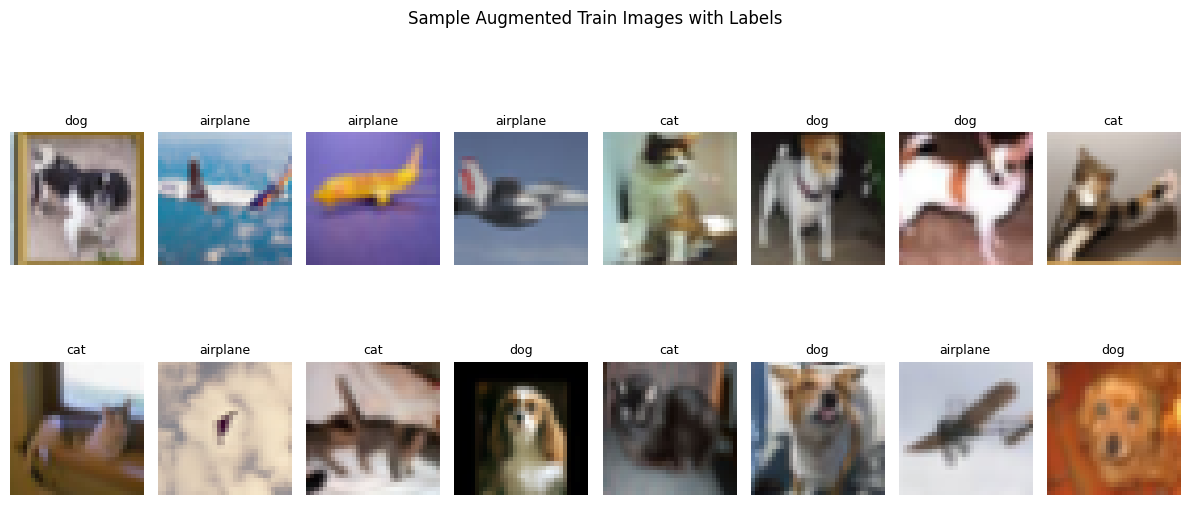

In [3]:
# 2) Data Pipeline (2.1 Dataset Preparation, 2.2 Data Augmentation)
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# ---- Config ----
SELECTED_CLASSES = ["airplane", "cat", "dog"]  # choose any 2–3 classes
BATCH_SIZE = 64
VAL_SPLIT = 0.1   # we will split CIFAR-10 train into train/val

# ---- Load CIFAR-10 ----
train_full = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
test_full = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

# CIFAR-10 class names
cifar_classes = train_full.classes
print("CIFAR-10 classes:", cifar_classes)

# ---- Filter for selected classes ----
selected_ids = [cifar_classes.index(c) for c in SELECTED_CLASSES]
print(f"\nSelected classes: {SELECTED_CLASSES}")
print(f"Original IDs: {selected_ids}")

# Map old label → new contiguous label
id2new = {old: new for new, old in enumerate(selected_ids)}
name2new = {cifar_classes[old]: new for old, new in id2new.items()}
print("Mapping (old_id → new_id):", id2new)
print("Mapping (name → new_id):", name2new)

# Filtering helper
def filter_dataset(dataset, selected_ids, id2new):
    imgs, labels = [], []
    for x, y in zip(dataset.data, dataset.targets):
        if y in selected_ids:
            imgs.append(x)
            labels.append(id2new[y])
    return np.array(imgs), labels

train_imgs, train_labels = filter_dataset(train_full, selected_ids, id2new)
test_imgs, test_labels = filter_dataset(test_full, selected_ids, id2new)

# ---- Train/Val split from filtered train ----
n_total = len(train_labels)
n_val = int(n_total * VAL_SPLIT)
n_train = n_total - n_val

indices = np.random.permutation(n_total)
train_idx, val_idx = indices[:n_train], indices[n_train:]

train_imgs_split, val_imgs_split = train_imgs[train_idx], train_imgs[val_idx]
train_labels_split = np.array(train_labels)[train_idx]
val_labels_split = np.array(train_labels)[val_idx]

# Count per class
def count_labels(labels):
    c = Counter(labels)
    return {cls: c[cls] for cls in range(len(SELECTED_CLASSES))}

print("\nClass counts:")
print("Train:", count_labels(train_labels_split))
print("Val:  ", count_labels(val_labels_split))
print("Test: ", count_labels(test_labels))

# ---- 2.2 Data Augmentation ----
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

print("\nTransform summary:")
print("Train:", train_transform)
print("Val:", val_transform)

# ---- Wrap in custom dataset ----
class CustomCIFAR(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x, y = self.images[idx], self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

train_ds = CustomCIFAR(train_imgs_split, train_labels_split, transform=train_transform)
val_ds   = CustomCIFAR(val_imgs_split, val_labels_split, transform=val_transform)
test_ds  = CustomCIFAR(test_imgs, test_labels, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ---- Sample batch shape ----
xb, yb = next(iter(train_loader))
print(f"\nTrain batch shape: {xb.shape}, labels: {yb.shape}")
xbv, ybv = next(iter(val_loader))
print(f"Val batch shape: {xbv.shape}, labels: {ybv.shape}")

# ---- Optional: show grid of augmented train images ----
def show_batch(x, y, classes):
    x = x[:16].cpu()
    y = y[:16].cpu()

    # Denormalize (back to [0,1] range for display)
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    x = x * std + mean  

    # Plot 16 images with labels
    plt.figure(figsize=(12, 6))
    for i in range(len(x)):
        img = x[i].numpy().transpose((1, 2, 0))
        label_id = y[i].item()
        label_name = [k for k, v in name2new.items() if v == label_id][0]

        plt.subplot(2, 8, i + 1)   # 2 rows × 8 columns
        plt.imshow(np.clip(img, 0, 1))
        plt.axis("off")
        plt.title(label_name, fontsize=9)

    plt.suptitle("Sample Augmented Train Images with Labels", fontsize=12)
    plt.tight_layout()
    plt.show()

show_batch(xb, yb, name2new)


In [4]:
## 3) Training & Evaluation

Epoch 1/15 | Train Loss: 0.467 | Train Acc: 79.5% | Val Loss: 0.399 | Val Acc: 83.7%
Epoch 2/15 | Train Loss: 0.341 | Train Acc: 85.4% | Val Loss: 0.396 | Val Acc: 84.9%
Epoch 3/15 | Train Loss: 0.295 | Train Acc: 87.8% | Val Loss: 0.351 | Val Acc: 84.3%
Epoch 4/15 | Train Loss: 0.264 | Train Acc: 88.9% | Val Loss: 0.348 | Val Acc: 86.8%
Epoch 5/15 | Train Loss: 0.237 | Train Acc: 90.2% | Val Loss: 0.360 | Val Acc: 85.1%
Epoch 6/15 | Train Loss: 0.198 | Train Acc: 92.1% | Val Loss: 0.401 | Val Acc: 84.7%
Epoch 7/15 | Train Loss: 0.189 | Train Acc: 92.6% | Val Loss: 0.351 | Val Acc: 87.7%
Epoch 8/15 | Train Loss: 0.174 | Train Acc: 93.1% | Val Loss: 0.381 | Val Acc: 85.6%
Epoch 9/15 | Train Loss: 0.162 | Train Acc: 93.6% | Val Loss: 0.345 | Val Acc: 87.4%
Epoch 10/15 | Train Loss: 0.148 | Train Acc: 94.3% | Val Loss: 0.386 | Val Acc: 86.7%
Epoch 11/15 | Train Loss: 0.137 | Train Acc: 94.6% | Val Loss: 0.427 | Val Acc: 84.7%
Epoch 12/15 | Train Loss: 0.130 | Train Acc: 94.8% | Val Loss: 

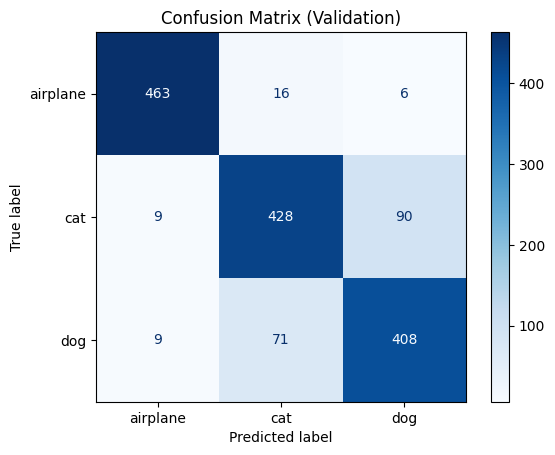


Classification Report:
              precision    recall  f1-score   support

    airplane       0.96      0.95      0.96       485
         cat       0.83      0.81      0.82       527
         dog       0.81      0.84      0.82       488

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



In [5]:

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ---- Config ----
EPOCHS = 15          # keep small for CPU runtime
LR = 3e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Loss & Optimizer ----
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ---- Helper: Accuracy ----
def accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().item() / len(y_true)

# ---- Training Loop ----
best_val_acc = 0.0
best_epoch = -1
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

model = model.to(device)

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    train_loss, train_correct, n_train = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        train_correct += (out.argmax(1) == yb).sum().item()
        n_train += xb.size(0)

    train_loss /= n_train
    train_acc = train_correct / n_train

    # Validation
    model.eval()
    val_loss, val_correct, n_val = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)

            val_loss += loss.item() * xb.size(0)
            preds = out.argmax(1)
            val_correct += (preds == yb).sum().item()
            n_val += xb.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    val_loss /= n_val
    val_acc = val_correct / n_val

    # Track history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Print epoch summary
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.1f}% | "
          f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.1f}%")

    # Track best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

print(f"\nBest Val Acc: {best_val_acc*100:.2f}% (epoch {best_epoch})")

# ---- 3.2 Performance Reporting ----
print(f"\nFinal Val Acc: {history['val_acc'][-1]*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=SELECTED_CLASSES)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.show()

# Optional: classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=SELECTED_CLASSES))


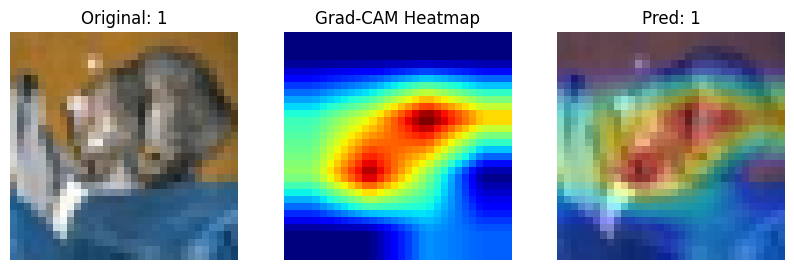

In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ---- Grad-CAM Class ----
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, class_idx):
        # global average pooling of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        gradcam = (weights * self.activations).sum(dim=1, keepdim=True)
        gradcam = F.relu(gradcam)

        # normalize
        gradcam = F.interpolate(gradcam, size=(32, 32), mode="bilinear", align_corners=False)
        gradcam = gradcam.squeeze().cpu().numpy()
        gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-8)
        return gradcam

# ---- Setup ----
# Example: attach GradCAM to last ResNet block
target_layer = model.layer2[-1]
gradcam = GradCAM(model, target_layer)

# ---- Run on one sample ----
model.eval()
img, label = test_ds[0]   # one CIFAR test sample
input_tensor = img.unsqueeze(0).to(device)

# forward
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# backward for Grad-CAM
model.zero_grad()
one_hot = torch.zeros_like(output)
one_hot[0, pred_class] = 1
output.backward(gradient=one_hot)

# generate heatmap
heatmap = gradcam.generate(pred_class)

# ---- Overlay ----
img_np = img.permute(1,2,0).numpy()
img_np = (img_np * np.array([0.2023,0.1994,0.2010]) + np.array([0.4914,0.4822,0.4465]))  # de-normalize
img_np = np.clip(img_np, 0, 1)

heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
overlay = 0.4*heatmap_color/255.0 + 0.6*img_np

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(img_np); plt.title(f"Original: {label}"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(heatmap, cmap="jet"); plt.title("Grad-CAM Heatmap"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(np.clip(overlay,0,1)); plt.title(f"Pred: {pred_class}"); plt.axis("off")
plt.show()
